### **Importations**

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
!pip install pmdarima

     -------------------------------------- 571.9/571.9 kB 1.4 MB/s eta 0:00:00

In [97]:
import json
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [53]:
all_data = pd.read_csv("all_data.csv",parse_dates=['date'],decimal=",")
all_data.head(2)

,ville,temperature,precipitation,date,barrages,capacite_normal_mm3,reserve_mm3,taux_de_remplissage_percent,reserve_mm3_last_year,taux_de_remplissage_percent_last_year,region
0,Marrakech,18,0.0,2021-03-13,LALLA TAKERKOUST,53.3,16.6,31.1,3.6,6.7,Marrakech-Safi
1,Marrakech,21,0.0,2021-03-14,LALLA TAKERKOUST,53.3,16.6,31.1,3.6,6.7,Marrakech-Safi


In [51]:
all_data.columns

Index(['ville', 'temperature', 'precipitation', 'date', 'barrages',
       'capacite_normal_mm3', 'reserve_mm3', 'taux_de_remplissage_percent',
       'reserve_mm3_last_year', 'taux_de_remplissage_percent_last_year',
       'region'],
      dtype='object')

In [55]:
all_data.astype({'temperature':'float64','precipitation':'float64','capacite_normal_mm3':'float64','reserve_mm3':'float64','taux_de_remplissage_percent':'float64','reserve_mm3_last_year':'float64','taux_de_remplissage_percent_last_year':'float64'})
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   ville                                  206 non-null    object        
 1   temperature                            206 non-null    int64         
 2   precipitation                          206 non-null    object        
 3   date                                   206 non-null    datetime64[ns]
 4   barrages                               206 non-null    object        
 5   capacite_normal_mm3                    206 non-null    float64       
 6   reserve_mm3                            206 non-null    float64       
 7   taux_de_remplissage_percent            206 non-null    float64       
 8   reserve_mm3_last_year                  206 non-null    float64       
 9   taux_de_remplissage_percent_last_year  206 non-null    float64   

### **Exploration de la série**

In [65]:
# all_data.set_index('date',inplace=True)
all_data.convert_dtypes().dtypes

ville                                     string
temperature                                Int64
precipitation                             string
barrages                                  string
capacite_normal_mm3                      Float64
reserve_mm3                              Float64
taux_de_remplissage_percent              Float64
reserve_mm3_last_year                    Float64
taux_de_remplissage_percent_last_year    Float64
region                                    string
dtype: object

In [98]:
all_data.describe()

,temperature,capacite_normal_mm3,reserve_mm3,taux_de_remplissage_percent,reserve_mm3_last_year,taux_de_remplissage_percent_last_year
count,206.000000,206.0,206.000000,206.000000,206.000000,206.000000
mean,27.325243,53.3,11.079612,20.787864,3.866019,7.253398
std,5.520343,0.0,4.784280,8.982443,0.500644,0.941749
min,13.000000,53.3,4.000000,7.500000,3.100000,5.800000
25%,23.000000,53.3,7.225000,13.550000,3.600000,6.700000
50%,28.000000,53.3,9.550000,17.850000,3.600000,6.800000
75%,31.000000,53.3,15.475000,29.050000,4.200000,7.800000
max,41.000000,53.3,21.500000,40.400000,5.000000,9.400000


### **Modèle 1 : SARIMAX**

#### **Saisonalité**

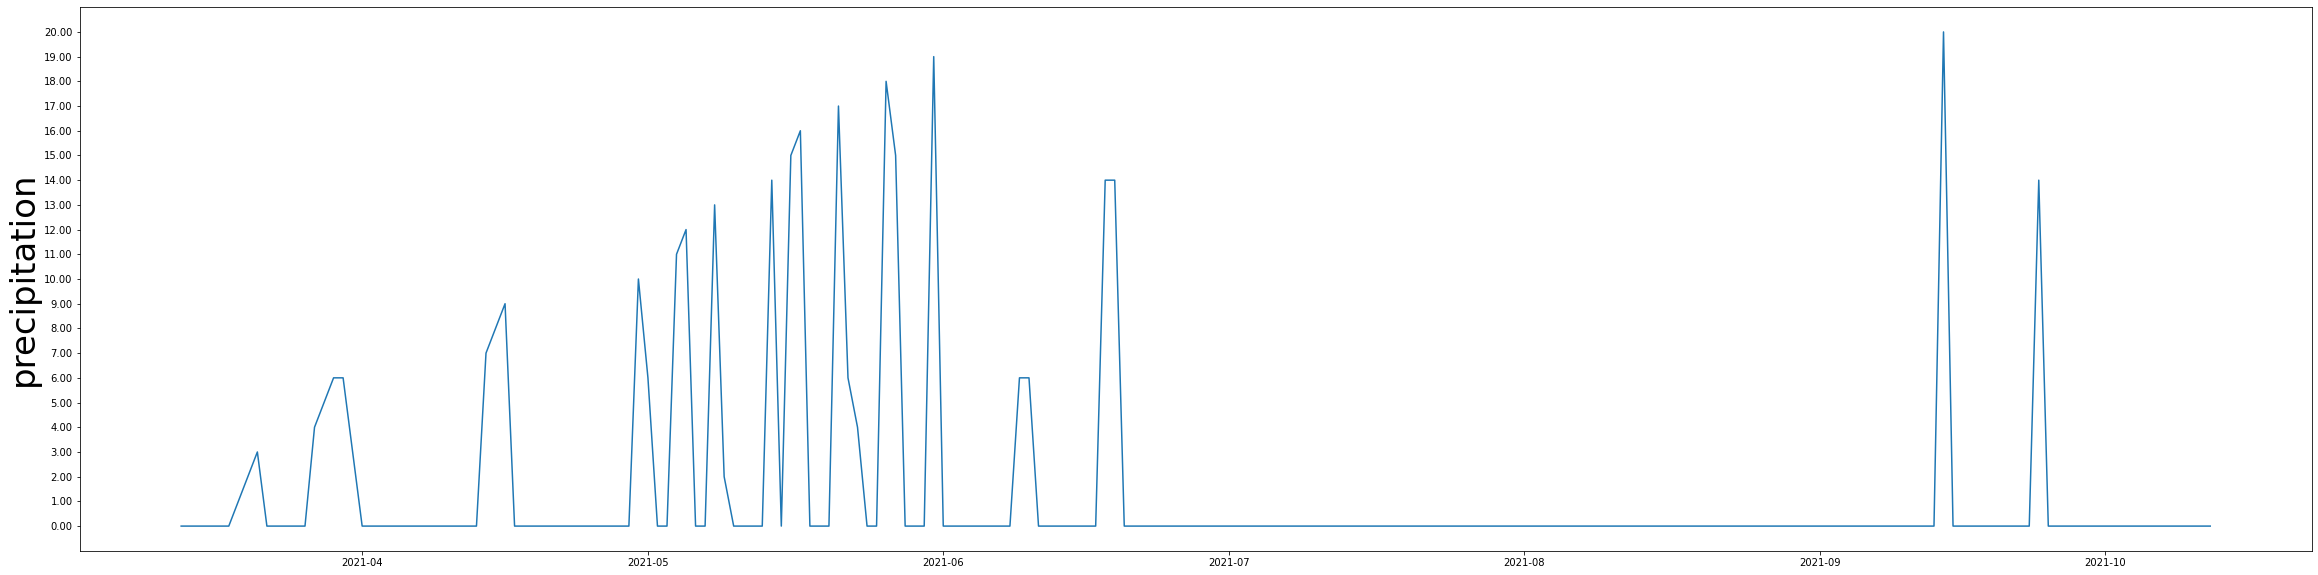

In [82]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(40, 10))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylabel('precipitation',fontsize=34)                                   
plt.plot(all_data['precipitation'])

Text(0.5, 1.0, 'Taux de remplissage en fctn du temps')

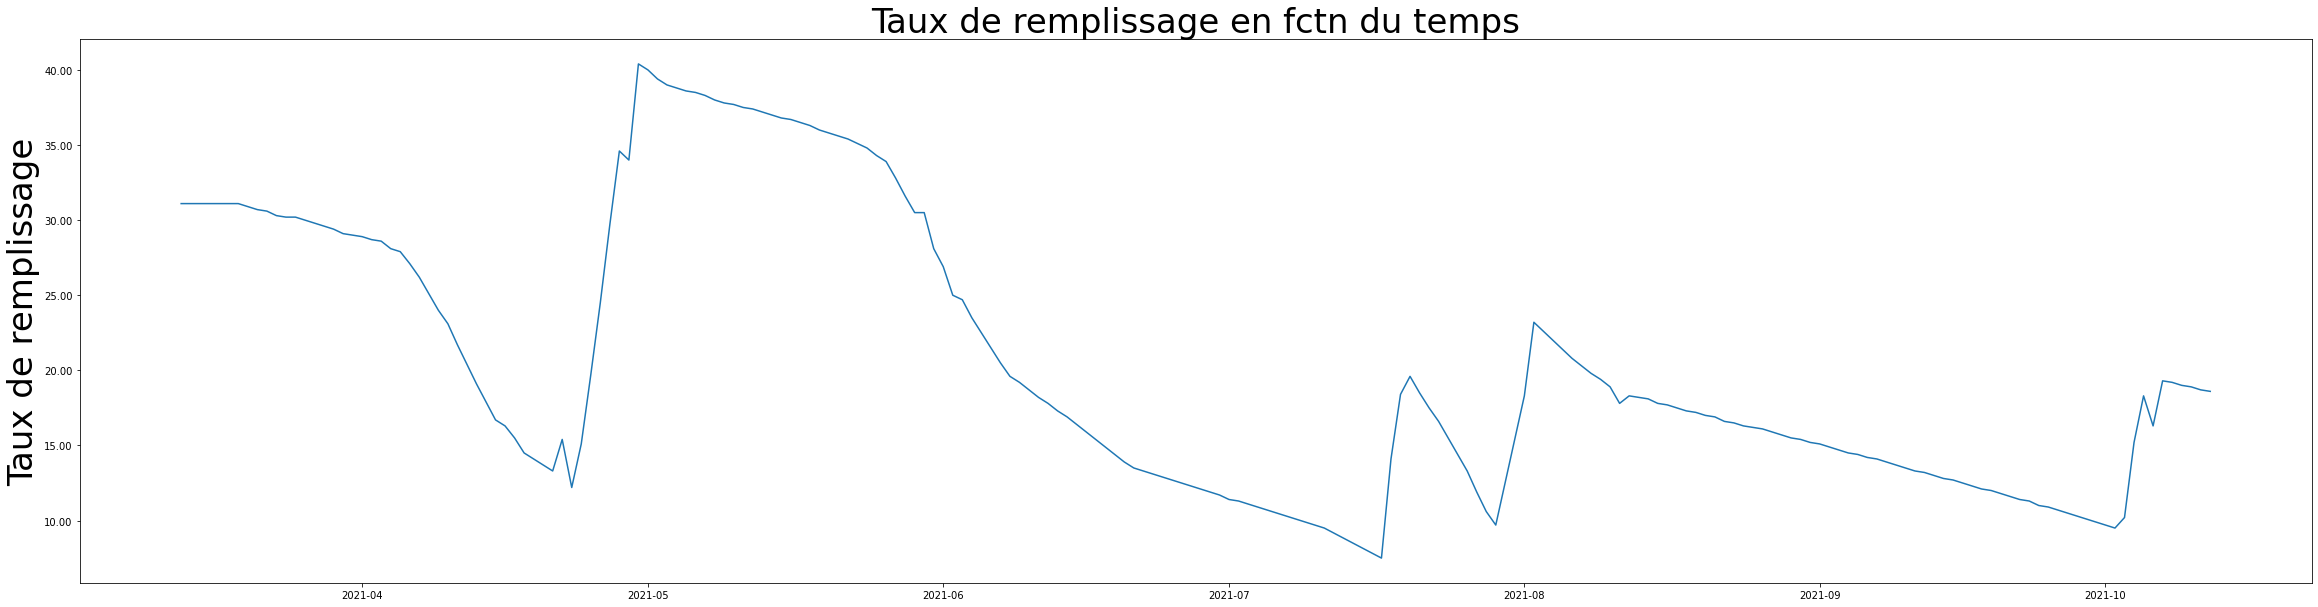

In [88]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(40, 10))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                             
plt.ylabel('Taux de remplissage',fontsize=34)                             
plt.plot(all_data['taux_de_remplissage_percent'])
plt.title('Taux de remplissage en fctn du temps',fontsize=34)

✔  On remarque qui'il n y'a pas un pattern qui se repete sur une intervalle donée donc pas de saisonalité

#### **Stationnarité**

* **Par observation**

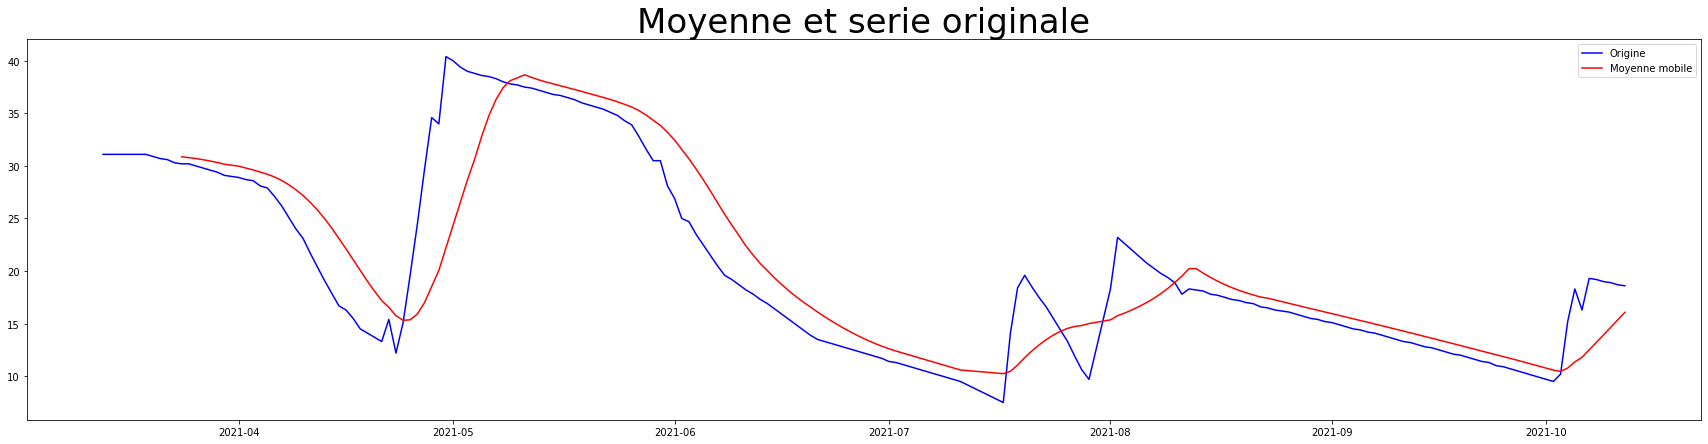

In [87]:
fig, ax = plt.subplots(figsize=(30, 7))
rolling_mean = all_data["taux_de_remplissage_percent"].rolling(window = 12).mean()
plt.plot(all_data["taux_de_remplissage_percent"], color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et serie originale',fontsize=34)
plt.show()

✔ On remarque les grandes variations  du  moyen mobile varie  donc on peut estimer que notre série de données n'est pas stationnaire

* **Par test de Dickey Fuller**

In [86]:
result = adfuller(all_data["taux_de_remplissage_percent"])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -2.0257393240682187
p-value : 0.27540256620318554
Valeurs Critiques :
	1%: -3.465058702600837
	5%: -2.8767942675230356
	10%: -2.5749014492475535


✔  P-value > 0.05 alors on est sure de la non stationnarité

#### **Solution : Autoregressif Integrated Moving average**

Le modèle qui sera le plus adéquat dans cet situation est le modèle : **ARIMA** qui sert à surmonter le problem de la non stationnarité. <br><br>
Le modèle ARIMA ajoute une différence à un modèle ARMA. La différenciation soustrait la valeur actuelle de la précédente et peut être utilisée pour transformer une série temporelle en une série stationnaire. Par exemple, la différenciation du premier ordre traite des tendances linéaires et utilise la transformation zi = yi – yi-1.
La différenciation du second ordre traite des tendances quadratiques et utilise une différence du premier ordre sur une différence du premier ordre, à savoir zi = (yi – yi-1) – (yi-1 – yi-2), et ainsi de suite.

In [96]:
model = auto_arima(all_data["taux_de_remplissage_percent"],test='adf',seasonal=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  206
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -351.310
Date:                Sat, 12 Nov 2022   AIC                            706.621
Time:                        23:57:56   BIC                            713.267
Sample:                             0   HQIC                           709.309
                                - 206                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3780      0.038     10.068      0.000       0.304       0.452
sigma2         1.8018      0.061     29.686      0.000       1.683       1.921
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              2952.17
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             3.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### **Evaluation**

##### Splitting en train et test

In [ ]:
train = all_data["taux_de_remplissage_percent"].iloc[:532]
valid = all_data["taux_de_remplissage_percent"].iloc[532:]
fig, ax = plt.subplots(figsize=(30, 10))

#plotting the data
plt.plot(train['prcp'], color = 'red', label='train data') 
plt.plot(valid['prcp'], color = 'green', label ='test data')
fig.legend(fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt. show()

In [ ]:
# Forecast
n_periods = 5
forecast, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_forecast = np.arange(len(precipetation.prcp), len(precipetation.prcp)+n_periods)

In [ ]:
for i in range(0,len(forecast)):
    print('Value =', round (forecast[i],3),'  ;  Expected =', round(valid.values[i][0],3) )

##### **RMSE**

In [ ]:
# error = rmse(valid['prcp'],forecast)
# print('RMSE Error: ', error)

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=np.sqrt(mean_squared_error(valid['prcp'],forecast))
print(rmse)

### **Modèle 2 : Vector Autoregression**